Setup

In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

ModuleNotFoundError: No module named 'tqdm'

Load and Preprocess Video Data

In [2]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [3]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [07:00<00:00,  1.40s/it]


val :


100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


test :


100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


Create training, test and validation sets

In [4]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

Creating a model

The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters.

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

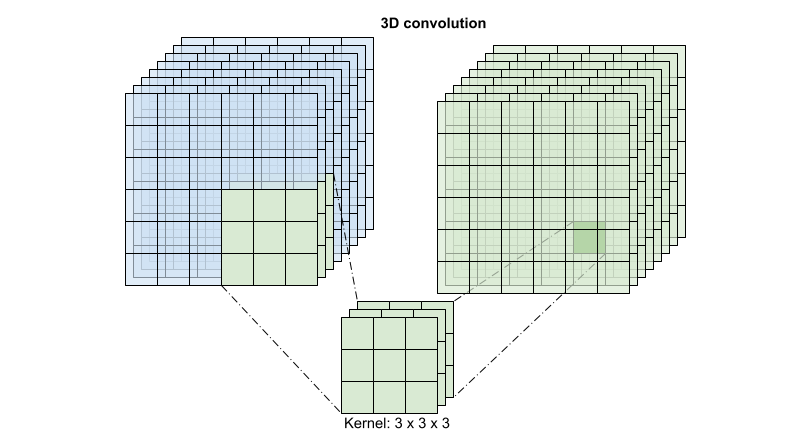

This operation is takes <b><h>time * height * width *</h></b> channels inputs and produces channels outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of (3 x 3 x 3) would need a weight-matrix with 27 * channels ** 2 entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a "(2+1)D" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

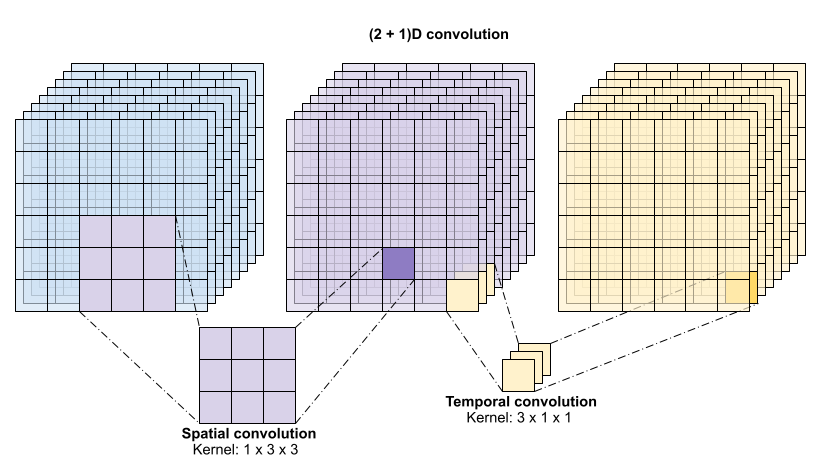

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape (1, width, height), while the temporal convolution takes in data of the shape (time, 1, 1). For example, a (2 + 1)D convolution with kernel size (3 x 3 x 3) would need weight matrices of size (9 * channels**2) + (3 * channels**2), less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [5]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [6]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

A ResNet model resnet model is made from a sequence of residual blocks. A residual block has two branches. The main branch performs the calculatoion, but is difficult for gradients to flow through. The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch. Gradients flow easily through this branch. Therefore, an easy path from the loss function to any of the residual block's main branch will be present. This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom Conv2Plus1D layer instead of layers.Conv2D.

In [7]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The <b><i>Project</b></i> layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.

In [8]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use <b><i>add_residual_block</b></i> to introduce a skip connection between the layers of the model.

In [9]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [20]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the <b><i>Keras functional API</b></i> to build the residual network.

In [21]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [22]:
frames, label = next(iter(train_ds))
model.build(frames)

In [14]:
import pydot
import graphviz

In [23]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Train the model

Choose the <i>tf.keras.optimizers.Adam</i> optimizer and the <i>tf.keras.losses.SparseCategoricalCrossentropy</i> loss function. Use the metrics argument to the view the accuracy of the model performance at every step.

In [24]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [25]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


TypeError: in user code:

    File "c:\Users\vivek\anaconda3\envs\Face_Recog_ML\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\vivek\anaconda3\envs\Face_Recog_ML\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\vivek\anaconda3\envs\Face_Recog_ML\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\vivek\anaconda3\envs\Face_Recog_ML\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\vivek\anaconda3\envs\Face_Recog_ML\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\vivek\AppData\Local\Temp\__autograph_generated_filepl7c9tml.py", line 22, in tf__call
        videos = ag__.converted_call(ag__.ld(einops).rearrange, (ag__.ld(images), '(b t) h w c -> b t h w c'), dict(t=ag__.ld(old_shape)['t']), fscope)
    File "C:\Users\vivek\AppData\Local\Temp\__autograph_generated_file3_o77trh.py", line 95, in tf__rearrange
        retval_ = ag__.converted_call(ag__.ld(reduce), (ag__.converted_call(ag__.ld(cast), (ag__.ld(Tensor), ag__.ld(tensor)), None, fscope), ag__.ld(pattern)), dict(reduction='rearrange', **ag__.ld(axes_lengths)), fscope)
    File "C:\Users\vivek\AppData\Local\Temp\__autograph_generated_filep46vpono.py", line 63, in tf__reduce
        recipe = ag__.converted_call(ag__.ld(_prepare_transformation_recipe), (ag__.ld(pattern), ag__.ld(reduction)), dict(axes_lengths=ag__.ld(hashable_axes_lengths)), fscope)

    TypeError: Exception encountered when calling layer 'resize_video_4' (type ResizeVideo).
    
    in user code:
    
        File "C:\Users\vivek\AppData\Local\Temp\ipykernel_19224\4004986950.py", line 23, in call  *
            videos = einops.rearrange(
        File "c:\Users\vivek\anaconda3\envs\Face_Recog_ML\lib\site-packages\einops\einops.py", line 483, in rearrange  *
            return reduce(cast(Tensor, tensor), pattern, reduction='rearrange', **axes_lengths)
        File "c:\Users\vivek\anaconda3\envs\Face_Recog_ML\lib\site-packages\einops\einops.py", line 411, in reduce  *
            recipe = _prepare_transformation_recipe(pattern, reduction, axes_lengths=hashable_axes_lengths)
    
        TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.
    
    
    Call arguments received by layer 'resize_video_4' (type ResizeVideo):
      • video=tf.Tensor(shape=(None, None, None, None, 16), dtype=float32)
